In [1]:
from __future__ import with_statement
import sys
import os
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np
import scipy as sp
import random
import distance
import matplotlib.pyplot as plt
import matplotlib
import itertools
import seaborn as sns
import statsmodels.api as sm 
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
# plt.rcParams["font.family"] = 'Helvetica'

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
from scipy.stats import nbinom


from stats import smooth
from plotutils import colormap_lch

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from adjustText import adjust_text
import pickle
# R = ro.r

%reload_ext rpy2.ipython
%matplotlib inline

In [2]:
#%R source("https://bioconductor.org/biocLite.R")
#%R biocLite("mpra")
%R library('mpra')

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, u

array(['mpra', 'limma', 'SummarizedExperiment', 'DelayedArray',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'stats4', 'BiocGenerics', 'parallel',
       'ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [3]:
%cd ~/basic/pan-viral/220414_NCfracset4/together/
%ls 

/casa/jenny/basic/pan-viral/220414_NCfracset4/together
C1.btw2.local.align.filter.process.bed  N1.btw2.local.align.filter.process.bed
C2.btw2.local.align.filter.process.bed  N2.btw2.local.align.filter.process.bed
C3.btw2.local.align.filter.process.bed  N3.btw2.local.align.filter.process.bed
C4.btw2.local.align.filter.process.bed  N4.btw2.local.align.filter.process.bed
D1.btw2.local.align.filter.process.bed  README
D2.btw2.local.align.filter.process.bed  WC1.btw2.local.align.filter.process.bed
D3.btw2.local.align.filter.process.bed  WC2.btw2.local.align.filter.process.bed
D4.btw2.local.align.filter.process.bed  WC3.btw2.local.align.filter.process.bed
fastq/                                  WC4.btw2.local.align.filter.process.bed


In [4]:
def log_tf(x):
    return np.log2(x+1)

def reject_outlier(numlist, m=2):
    u = np.mean(numlist)
    s = np.std(numlist)
    filtered = [e for e in numlist if (u - m* s < e < u + m * s)]
    return filtered

def is_CNGGN(x):
    if (x[0]=='C')  and (x[2:4]=='GG'):
        return True
    else:
        return False
    

def orthoregress(x, y):
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.
    Arguments:
    x: x data
    y: y data
    Returns:
    [m, c, nan, nan, nan]
    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()

    return list(out.beta)


def f(p, x):
    """Basic linear regression 'model' for use with ODR"""
    return (p[0] * x) + p[1]

In [5]:
colnames = ['C1','C2','C3','C4','N1','N2','N3','N4','WC1','WC2','WC3','WC4', 'D1','D2','D3','D4']
for i,s in enumerate(colnames):
    tmp = pd.read_csv('%s.btw2.local.align.filter.process.bed'%(s),sep=' ', names = ['alignid','count'])
#     tmp = tmp[tmp['qual']=='T']
#     tmp = tmp.groupby('alignid').count()['qual'].reset_index()
#     print(tmp.head())
    tmp.columns = ['alignid', 'count_%s'%(colnames[i])]
    print(s, tmp.shape, len(set(tmp['alignid'])))
    if i==0:
        countBC_merge = tmp
    else:
        countBC_merge = pd.merge(countBC_merge, tmp, how='outer', on='alignid').fillna(0)

countBC_merge['species'] = countBC_merge['alignid'].apply(lambda x: '|'.join(x.split('|')[:-2]))
countBC_merge['virus'] = countBC_merge['species'].apply(lambda x: x.split('|')[1])
countBC_merge['site'] = countBC_merge['species'].apply(lambda x: x.split('|')[3])
countBC_merge['uniqID'] = countBC_merge['species'].apply(lambda x: x.split('|')[0])

count_merge = countBC_merge.groupby('species').sum().reset_index()
count_merge['virus'] = count_merge['species'].apply(lambda x: x.split('|')[1])
count_merge['site'] = count_merge['species'].apply(lambda x: x.split('|')[3])
count_merge['uniqID'] = count_merge['species'].apply(lambda x: x.split('|')[0])

count_merge.head()

C1 (89297, 2) 89297
C2 (89226, 2) 89226
C3 (89809, 2) 89809
C4 (89863, 2) 89863
N1 (89518, 2) 89518
N2 (89168, 2) 89168
N3 (89508, 2) 89508
N4 (89545, 2) 89545
WC1 (89638, 2) 89638
WC2 (89403, 2) 89403
WC3 (89454, 2) 89454
WC4 (89579, 2) 89579
D1 (90224, 2) 90224
D2 (90259, 2) 90259
D3 (89944, 2) 89944
D4 (89690, 2) 89690


,species,count_C1,count_C2,count_C3,count_C4,count_N1,count_N2,count_N3,count_N4,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,virus,site,uniqID
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",290.0,406.0,276.0,361.0,342.0,307.0,430.0,474.0,477.0,313.0,386.0,264.0,341.0,387.0,439.0,388.0,ROTAVIRUS_A,"1,130",TILE_ID_001-00001
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",298.0,227.0,205.0,313.0,338.0,302.0,264.0,328.0,399.0,125.0,348.0,344.0,245.0,235.0,337.0,251.0,ROTAVIRUS_A,"66,195",TILE_ID_001-00002
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",343.0,460.0,457.0,455.0,420.0,366.0,509.0,437.0,726.0,313.0,333.0,340.0,287.0,314.0,263.0,349.0,ROTAVIRUS_A,"131,260",TILE_ID_001-00003
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",500.0,891.0,905.0,632.0,826.0,771.0,773.0,829.0,1078.0,563.0,924.0,869.0,517.0,568.0,707.0,651.0,ROTAVIRUS_A,"196,325",TILE_ID_001-00004
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",320.0,396.0,375.0,251.0,239.0,338.0,382.0,491.0,487.0,171.0,304.0,274.0,155.0,236.0,334.0,211.0,ROTAVIRUS_A,"261,390",TILE_ID_001-00005


# N vs C

In [33]:
countBC_dna = countBC_merge.iloc[:,[0,5,6,7,8]].set_index('alignid')
countBC_dna['ctrl1'] = [50]*len(countBC_dna);countBC_dna['ctrl2'] = [50]*len(countBC_dna);
countBC_dna['ctrl3'] = [50]*len(countBC_dna);countBC_dna['ctrl4'] = [50]*len(countBC_dna)
# countBC_dna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_dna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
countBC_rna = countBC_merge.iloc[:,[0,1,2,3,4]].set_index('alignid')
countBC_rna['ctrl1'] = [50]*len(countBC_rna);countBC_rna['ctrl2'] = [50]*len(countBC_rna);
countBC_rna['ctrl3'] = [50]*len(countBC_rna);countBC_rna['ctrl4'] = [50]*len(countBC_rna);
# countBC_rna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_rna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
species_list = list(countBC_merge.set_index('alignid')['species'])
countBC_dna = countBC_dna +20
countBC_rna = countBC_rna +20
countBC_dna.head()

,rep1,rep2,rep3,rep4,c1,c2,c3,c4
alignid,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ATCGGAA|0",59.0,75.0,84.0,72.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGTACAA|1",218.0,151.0,192.0,196.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|TAAGCGA|2",125.0,141.0,214.0,266.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ACTGGAA|0",133.0,96.0,103.0,103.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGATAGA|2",222.0,204.0,188.0,233.0,70,70,70,70


In [34]:
%Rpush countBC_dna
%Rpush countBC_rna
%Rpush species_list

%R species_list <- unlist(species_list)

array(['TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       ...,
       'TILE_ID_126-00320|HUMAN_CORONAVIRUS_HKU1_(HCOV-HKU1)|NC_006577.2|20814,20943|PRETILE_ID_126-00003|PREPRETILE_ID_126-00001',
       'TILE_ID_141-00231|NY_014_POXVIRUS|NC_035469.1|155593,155722|PRETILE_ID_141-00050|PREPRETILE_ID_141-00050',
       'TILE_ID_142-00108|COWPOX_VIRUS|NC_003663.2|97894,98023|PRETILE_ID_142-00023|PREPRETILE_ID_142-00023'],
      dtype='<U155')

In [35]:
%R mpraset_example <- MPRASet(DNA = countBC_dna, RNA = countBC_rna, eid = species_list, eseq = NULL, barcode = NULL)

R object with classes: ('MPRASet',) mapped to:

  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


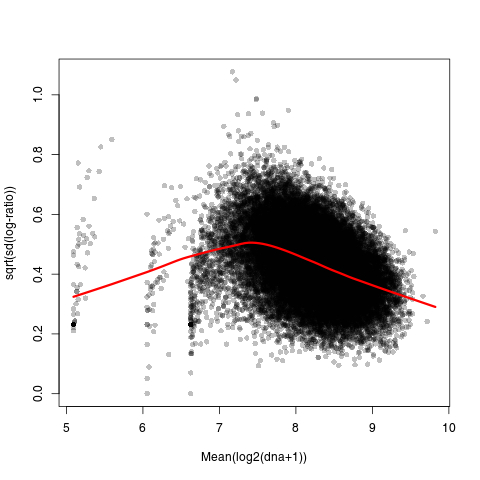

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_135-00259|HUMAN_ALPHAHERPESVIRUS_1_(HE...,1.920344,0.949189,19.977532,3.182927e-09,0.000096,7.674193
1,TILE_ID_140-00225|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,1.553792,0.762978,13.957635,9.342771e-08,0.000783,6.794340
2,"TILE_ID_133-00453|ORF_VIRUS|NC_005336.1|42729,...",2.140088,1.086232,17.031572,1.444771e-08,0.000219,6.540873
3,"TILE_ID_133-00560|ORF_VIRUS|NC_005336.1|95109,...",1.371068,0.682994,13.185495,1.584554e-07,0.000783,6.483674
4,TILE_ID_085-00041|RUBELLA_VIRUS|NC_001545.2|27...,2.466710,1.181433,13.226177,1.539993e-07,0.000783,6.247310


In [36]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "mean", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEresultmeanNC = pandas2ri.rpy2py_dataframe(toptab)
DEresultmeanNC = DEresultmeanNC.reset_index()
DEresultmeanNC.head()

[]

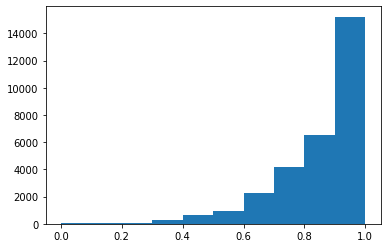

In [37]:
plt.hist(DEresultmeanNC['adj.P.Val'])
plt.plot()

In [38]:
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>0][DEresultmeanNC['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_listNC2 = list(tmp['index'])
print(stat_listNC2)
tmp

(50, 7)
['TILE_ID_085-00041|RUBELLA_VIRUS|NC_001545.2|2716,2845|PRETILE_ID_085-00003|PREPRETILE_ID_085-00001', 'TILE_ID_133-00299|ORF_VIRUS|NC_005336.1|134240,134369|PRETILE_ID_133-00088|PREPRETILE_ID_133-00060', 'TILE_ID_133-00453|ORF_VIRUS|NC_005336.1|42729,42600|PRETILE_ID_133-00125|PREPRETILE_ID_133-00087', 'TILE_ID_133-00323|ORF_VIRUS|NC_005336.1|3517,3388|PRETILE_ID_133-00092|PREPRETILE_ID_133-00064', 'TILE_ID_135-00259|HUMAN_ALPHAHERPESVIRUS_1_(HERPES_SIMPLEX_VIRUS_1)|NC_001806.2|122227,122356|PRETILE_ID_135-00043|PREPRETILE_ID_135-00029', 'TILE_ID_136-00151|HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)|NC_001798.2|52102,52231|PRETILE_ID_136-00030|PREPRETILE_ID_136-00015', 'TILE_ID_133-00503|ORF_VIRUS|NC_005336.1|77525,77396|PRETILE_ID_133-00140|PREPRETILE_ID_133-00097', 'TILE_ID_136-00353|HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)|NC_001798.2|139335,139464|PRETILE_ID_136-00061|PREPRETILE_ID_136-00030', 'TILE_ID_136-00303|HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
4,TILE_ID_085-00041|RUBELLA_VIRUS|NC_001545.2|27...,2.466710,1.181433,13.226177,1.539993e-07,0.000783,6.247310
16,TILE_ID_133-00299|ORF_VIRUS|NC_005336.1|134240...,2.312164,1.076164,9.852124,2.248965e-06,0.004004,4.472390
2,"TILE_ID_133-00453|ORF_VIRUS|NC_005336.1|42729,...",2.140088,1.086232,17.031572,1.444771e-08,0.000219,6.540873
11,"TILE_ID_133-00323|ORF_VIRUS|NC_005336.1|3517,3...",2.094890,1.058623,10.960757,8.620260e-07,0.002007,5.347425
0,TILE_ID_135-00259|HUMAN_ALPHAHERPESVIRUS_1_(HE...,1.920344,0.949189,19.977532,3.182927e-09,0.000096,7.674193
5,TILE_ID_136-00151|HUMAN_ALPHAHERPESVIRUS_2_(HE...,1.911091,0.923394,13.272269,1.491160e-07,0.000783,6.168020
10,"TILE_ID_133-00503|ORF_VIRUS|NC_005336.1|77525,...",1.902410,0.999924,10.730632,1.044515e-06,0.002258,5.352159
9,TILE_ID_136-00353|HUMAN_ALPHAHERPESVIRUS_2_(HE...,1.877834,0.948635,11.212868,7.012566e-07,0.001903,5.578180
6,TILE_ID_136-00303|HUMAN_ALPHAHERPESVIRUS_2_(HE...,1.825287,0.898584,12.996618,1.810839e-07,0.000783,5.964233
15,TILE_ID_136-00089|HUMAN_ALPHAHERPESVIRUS_2_(HE...,1.784454,0.879330,10.635805,1.131686e-06,0.002284,4.665482


# WC vs C

In [26]:
countBC_dna = countBC_merge.iloc[:,[0,9,10,11,12]].set_index('alignid')
countBC_dna['ctrl1'] = [50]*len(countBC_dna);countBC_dna['ctrl2'] = [50]*len(countBC_dna);
countBC_dna['ctrl3'] = [50]*len(countBC_dna);countBC_dna['ctrl4'] = [50]*len(countBC_dna)
# countBC_dna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_dna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
countBC_rna = countBC_merge.iloc[:,[0,1,2,3,4]].set_index('alignid')
countBC_rna['ctrl1'] = [50]*len(countBC_rna);countBC_rna['ctrl2'] = [50]*len(countBC_rna);
countBC_rna['ctrl3'] = [50]*len(countBC_rna);countBC_rna['ctrl4'] = [50]*len(countBC_rna);
# countBC_rna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_rna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
species_list = list(countBC_merge.set_index('alignid')['species'])
countBC_dna = countBC_dna +20
countBC_rna = countBC_rna +20
countBC_dna.head()

,rep1,rep2,rep3,rep4,c1,c2,c3,c4
alignid,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ATCGGAA|0",90.0,46.0,83.0,67.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGTACAA|1",296.0,138.0,194.0,103.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|TAAGCGA|2",151.0,189.0,169.0,154.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ACTGGAA|0",122.0,50.0,134.0,122.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGATAGA|2",240.0,86.0,238.0,210.0,70,70,70,70


In [27]:
%Rpush countBC_dna
%Rpush countBC_rna
%Rpush species_list

%R species_list <- unlist(species_list)

array(['TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       ...,
       'TILE_ID_126-00320|HUMAN_CORONAVIRUS_HKU1_(HCOV-HKU1)|NC_006577.2|20814,20943|PRETILE_ID_126-00003|PREPRETILE_ID_126-00001',
       'TILE_ID_141-00231|NY_014_POXVIRUS|NC_035469.1|155593,155722|PRETILE_ID_141-00050|PREPRETILE_ID_141-00050',
       'TILE_ID_142-00108|COWPOX_VIRUS|NC_003663.2|97894,98023|PRETILE_ID_142-00023|PREPRETILE_ID_142-00023'],
      dtype='<U155')

In [28]:
%R mpraset_example <- MPRASet(DNA = countBC_dna, RNA = countBC_rna, eid = species_list, eseq = NULL, barcode = NULL)

R object with classes: ('MPRASet',) mapped to:

  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


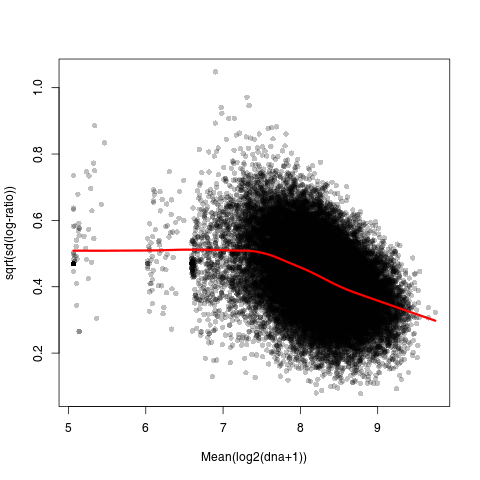

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_140-00170|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,0.669415,0.334565,11.096169,5.716269e-07,0.009497,5.693902
1,TILE_ID_135-00001|HUMAN_ALPHAHERPESVIRUS_1_(HE...,0.835453,0.420663,10.982502,6.294916e-07,0.009497,5.308871
2,TILE_ID_085-00041|RUBELLA_VIRUS|NC_001545.2|27...,1.359561,0.683143,10.280137,1.164909e-06,0.009497,3.983094
3,TILE_ID_140-00233|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,0.786776,0.400716,8.486947,6.677500e-06,0.020138,3.978392
4,"TILE_ID_133-00323|ORF_VIRUS|NC_005336.1|3517,3...",1.380745,0.689014,10.197769,1.255001e-06,0.009497,3.851021


In [29]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "mean", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEresultmeanWCC = pandas2ri.rpy2py_dataframe(toptab)
DEresultmeanWCC = DEresultmeanWCC.reset_index()
DEresultmeanWCC.head()

[]

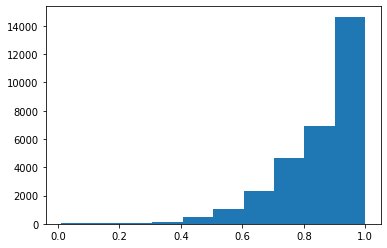

In [30]:
plt.hist(DEresultmeanWCC['adj.P.Val'])
plt.plot()

In [31]:
tmp = DEresultmeanWCC[DEresultmeanWCC['logFC']>0][DEresultmeanWCC['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_listWCC2 = list(tmp['index'])
print(stat_listWCC2)
tmp

(30, 7)
['TILE_ID_133-00323|ORF_VIRUS|NC_005336.1|3517,3388|PRETILE_ID_133-00092|PREPRETILE_ID_133-00064', 'TILE_ID_085-00041|RUBELLA_VIRUS|NC_001545.2|2716,2845|PRETILE_ID_085-00003|PREPRETILE_ID_085-00001', 'TILE_ID_133-00299|ORF_VIRUS|NC_005336.1|134240,134369|PRETILE_ID_133-00088|PREPRETILE_ID_133-00060', 'TILE_ID_133-00503|ORF_VIRUS|NC_005336.1|77525,77396|PRETILE_ID_133-00140|PREPRETILE_ID_133-00097', 'TILE_ID_136-00084|HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)|NC_001798.2|32604,32733|PRETILE_ID_136-00018|PREPRETILE_ID_136-00011', 'TILE_ID_133-00123|ORF_VIRUS|NC_005336.1|67667,67796|PRETILE_ID_133-00039|PREPRETILE_ID_133-00025', 'TILE_ID_136-00353|HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)|NC_001798.2|139335,139464|PRETILE_ID_136-00061|PREPRETILE_ID_136-00030', 'TILE_ID_135-00259|HUMAN_ALPHAHERPESVIRUS_1_(HERPES_SIMPLEX_VIRUS_1)|NC_001806.2|122227,122356|PRETILE_ID_135-00043|PREPRETILE_ID_135-00029', 'TILE_ID_133-00149|ORF_VIRUS|NC_005336.1|74526,74655|PRETILE_ID_1

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
4,"TILE_ID_133-00323|ORF_VIRUS|NC_005336.1|3517,3...",1.380745,0.689014,10.197769,1.255001e-06,0.009497,3.851021
2,TILE_ID_085-00041|RUBELLA_VIRUS|NC_001545.2|27...,1.359561,0.683143,10.280137,1.164909e-06,0.009497,3.983094
6,TILE_ID_133-00299|ORF_VIRUS|NC_005336.1|134240...,1.327917,0.638302,9.145255,3.407001e-06,0.014732,3.538830
32,"TILE_ID_133-00503|ORF_VIRUS|NC_005336.1|77525,...",1.317199,0.658938,6.203730,9.795634e-05,0.092658,1.205119
8,TILE_ID_136-00084|HUMAN_ALPHAHERPESVIRUS_2_(HE...,1.291428,0.646924,9.189384,3.261281e-06,0.014732,3.344429
31,"TILE_ID_133-00123|ORF_VIRUS|NC_005336.1|67667,...",1.269272,0.634653,6.369391,7.894167e-05,0.079650,1.358336
13,TILE_ID_136-00353|HUMAN_ALPHAHERPESVIRUS_2_(HE...,1.253384,0.626319,8.105570,1.004858e-05,0.025347,2.700459
16,TILE_ID_135-00259|HUMAN_ALPHAHERPESVIRUS_1_(HE...,1.239870,0.617269,7.404285,2.216053e-05,0.041607,2.264245
18,"TILE_ID_133-00149|ORF_VIRUS|NC_005336.1|74526,...",1.215865,0.607425,7.301998,2.498276e-05,0.041607,2.134596
19,TILE_ID_133-00269|ORF_VIRUS|NC_005336.1|126797...,1.185743,0.592522,7.264365,2.611708e-05,0.041607,2.106228


In [32]:
tmp = DEresultmeanWCC[DEresultmeanWCC['logFC']<0][DEresultmeanWCC['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
negstat_listWCC2 = list(tmp['index'])
print(negstat_listWCC2)
tmp

(2, 7)
['TILE_ID_076-00125|BORNA_DISEASE_VIRUS_1_(BODV-1)|NC_001607.1|8313,8442|PRETILE_ID_076-00007|PREPRETILE_ID_076-00001', 'TILE_ID_122-00289|HUMAN_CORONAVIRUS_NL63_(HCOV-NL63)|NC_005831.2|18746,18875|PRETILE_ID_122-00002|PREPRETILE_ID_122-00001']


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
23,TILE_ID_076-00125|BORNA_DISEASE_VIRUS_1_(BODV-...,-0.472082,-0.236108,-6.467978,0.000070,0.075180,1.895126
22,TILE_ID_122-00289|HUMAN_CORONAVIRUS_NL63_(HCOV...,-0.583187,-0.284400,-6.656125,0.000055,0.063789,1.917413


# D vs C

In [6]:
countBC_dna = countBC_merge.iloc[:,[0,13,14,15,16]].set_index('alignid')
countBC_dna['ctrl1'] = [50]*len(countBC_dna);countBC_dna['ctrl2'] = [50]*len(countBC_dna);
countBC_dna['ctrl3'] = [50]*len(countBC_dna);countBC_dna['ctrl4'] = [50]*len(countBC_dna)
# countBC_dna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_dna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
countBC_rna = countBC_merge.iloc[:,[0,1,2,3,4]].set_index('alignid')
countBC_rna['ctrl1'] = [50]*len(countBC_rna);countBC_rna['ctrl2'] = [50]*len(countBC_rna);
countBC_rna['ctrl3'] = [50]*len(countBC_rna);countBC_rna['ctrl4'] = [50]*len(countBC_rna);
# countBC_rna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_rna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
species_list = list(countBC_merge.set_index('alignid')['species'])
countBC_dna = countBC_dna +20
countBC_rna = countBC_rna +20
countBC_dna.head()

,rep1,rep2,rep3,rep4,c1,c2,c3,c4
alignid,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ATCGGAA|0",134.0,110.0,115.0,116.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGTACAA|1",132.0,148.0,159.0,167.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|TAAGCGA|2",135.0,189.0,225.0,165.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ACTGGAA|0",90.0,56.0,89.0,29.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGATAGA|2",150.0,195.0,244.0,223.0,70,70,70,70


In [7]:
%Rpush countBC_dna
%Rpush countBC_rna
%Rpush species_list

%R species_list <- unlist(species_list)

array(['TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       ...,
       'TILE_ID_126-00320|HUMAN_CORONAVIRUS_HKU1_(HCOV-HKU1)|NC_006577.2|20814,20943|PRETILE_ID_126-00003|PREPRETILE_ID_126-00001',
       'TILE_ID_141-00231|NY_014_POXVIRUS|NC_035469.1|155593,155722|PRETILE_ID_141-00050|PREPRETILE_ID_141-00050',
       'TILE_ID_142-00108|COWPOX_VIRUS|NC_003663.2|97894,98023|PRETILE_ID_142-00023|PREPRETILE_ID_142-00023'],
      dtype='<U155')

In [8]:
%R mpraset_example <- MPRASet(DNA = countBC_dna, RNA = countBC_rna, eid = species_list, eseq = NULL, barcode = NULL)

R object with classes: ('MPRASet',) mapped to:

  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


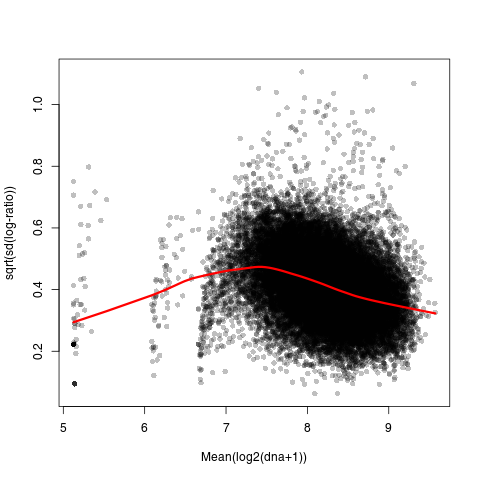

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_137-00483|HUMAN_BETAHERPESVIRUS_6B_(HH...,-3.677049,-1.838187,-54.894780,2.218575e-13,6.715404e-09,19.521294
1,TILE_ID_140-00634|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-2.839812,-1.419906,-41.637917,3.170412e-12,4.798260e-08,17.963612
2,TILE_ID_002-00242|GREAT_ISLAND_VIRUS_(GIV)|NC_...,-2.843063,-1.423240,-35.143907,1.614932e-11,1.227477e-07,16.447570
3,TILE_ID_132-00247|HUMAN_GAMMAHERPESVIRUS_8_(KA...,-2.545372,-1.272972,-35.127703,1.622091e-11,1.227477e-07,16.158038
4,TILE_ID_130-00391|INFECTIOUS_SPLEEN_AND_KIDNEY...,-2.945431,-1.471857,-31.576119,4.504969e-11,2.542778e-07,15.769242


In [9]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "mean", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEresultmeanDC = pandas2ri.rpy2py_dataframe(toptab)
DEresultmeanDC = DEresultmeanDC.reset_index()
DEresultmeanDC.head()

[]

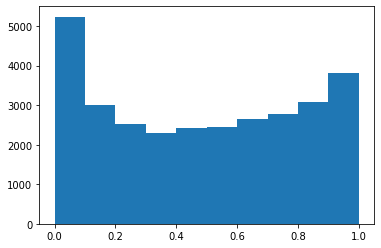

In [10]:
plt.hist(DEresultmeanDC['adj.P.Val'])
plt.plot()

In [12]:
tmp = DEresultmeanDC[DEresultmeanDC['logFC']>0][DEresultmeanDC['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_listDC2 = list(tmp['index'])
print(len(stat_listDC2))
tmp

(1893, 7)
1893


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
35,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.766647,0.890566,22.256725,1.265942e-09,0.000001,12.793287
3521,TILE_ID_135-00011|HUMAN_ALPHAHERPESVIRUS_1_(HE...,1.570538,0.648246,3.616795,4.986877e-03,0.043931,-2.884227
496,TILE_ID_143-00201|HUMAN_BETAHERPESVIRUS_5_(HHV...,1.346385,0.681855,10.342351,1.544138e-06,0.000095,5.635097
2972,TILE_ID_135-00010|HUMAN_ALPHAHERPESVIRUS_1_(HE...,1.289718,0.408585,3.985147,2.762530e-03,0.029004,-2.308510
605,TILE_ID_075-00103|HUSAVIRUS_SP.|NC_032480.1|66...,1.255397,0.633141,9.197531,4.357374e-06,0.000210,4.690195
...,...,...,...,...,...,...,...
5234,TILE_ID_107-00060|BOVINE_VIRAL_DIARRHEA_VIRUS_...,0.177425,0.089069,2.915224,1.596988e-02,0.094671,-4.064998
5473,TILE_ID_084-00013|HEPATITIS_C_VIRUS_GENOTYPE_1...,0.171825,0.085637,2.907442,1.618064e-02,0.095453,-4.182110
5302,TILE_ID_097-00058|TICK-BORNE_ENCEPHALITIS_VIRU...,0.168187,0.084269,2.952091,1.500881e-02,0.090806,-4.096856
5384,TILE_ID_083-00025|PEGIVIRUS_A|NC_001837.1|1561...,0.166846,0.083878,2.929359,1.559422e-02,0.093174,-4.138186


In [13]:
tmp = DEresultmeanDC[DEresultmeanDC['logFC']<0][DEresultmeanDC['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
negstat_listDC2 = list(tmp['index'])
# print(negstat_listWCC2)
tmp

(3342, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
5161,TILE_ID_135-00310|HUMAN_ALPHAHERPESVIRUS_1_(HE...,-0.163507,-0.082006,-3.033344,1.309320e-02,8.352328e-02,-4.018879
5143,TILE_ID_136-00279|HUMAN_ALPHAHERPESVIRUS_2_(HE...,-0.183481,-0.091080,-3.006566,1.369529e-02,8.579115e-02,-4.004425
5291,TILE_ID_097-00004|TICK-BORNE_ENCEPHALITIS_VIRU...,-0.184233,-0.090478,-2.945688,1.517140e-02,9.141181e-02,-4.092512
4797,TILE_ID_070-00052|AICHI_VIRUS_1|NC_001918.1|33...,-0.185395,-0.093308,-3.104533,1.162070e-02,7.727304e-02,-3.819565
5084,TILE_ID_131-00097|HUMAN_ALPHAHERPESVIRUS_3_(HH...,-0.185814,-0.092885,-2.994201,1.398276e-02,8.685496e-02,-3.973678
...,...,...,...,...,...,...,...
438,TILE_ID_070-00104|AICHI_VIRUS_1|NC_001918.1|66...,-3.247802,-1.621293,-10.885216,9.763319e-07,6.888716e-05,6.071263
158,"TILE_ID_133-00343|ORF_VIRUS|NC_005336.1|7275,7...",-3.294562,-1.646493,-15.644304,3.500565e-08,6.706242e-06,9.545446
148,TILE_ID_083-00058|PEGIVIRUS_A|NC_001837.1|3706...,-3.325592,-1.664447,-15.837528,3.121828e-08,6.341921e-06,9.657991
9,TILE_ID_137-00484|HUMAN_BETAHERPESVIRUS_6B_(HH...,-3.551088,-1.777347,-28.485033,1.206914e-10,3.606131e-07,14.919635


# WC vs N

In [21]:
countBC_dna = countBC_merge.iloc[:,[0,9,10,11,12]].set_index('alignid')
countBC_dna['ctrl1'] = [50]*len(countBC_dna);countBC_dna['ctrl2'] = [50]*len(countBC_dna);
countBC_dna['ctrl3'] = [50]*len(countBC_dna);countBC_dna['ctrl4'] = [50]*len(countBC_dna)
# countBC_dna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_dna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
countBC_rna = countBC_merge.iloc[:,[0,5,6,7,8]].set_index('alignid')
countBC_rna['ctrl1'] = [50]*len(countBC_rna);countBC_rna['ctrl2'] = [50]*len(countBC_rna);
countBC_rna['ctrl3'] = [50]*len(countBC_rna);countBC_rna['ctrl4'] = [50]*len(countBC_rna);
# countBC_rna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_rna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
species_list = list(countBC_merge.set_index('alignid')['species'])
countBC_dna = countBC_dna +20
countBC_rna = countBC_rna +20
countBC_dna.head()

,rep1,rep2,rep3,rep4,c1,c2,c3,c4
alignid,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ATCGGAA|0",90.0,46.0,83.0,67.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGTACAA|1",296.0,138.0,194.0,103.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|TAAGCGA|2",151.0,189.0,169.0,154.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ACTGGAA|0",122.0,50.0,134.0,122.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGATAGA|2",240.0,86.0,238.0,210.0,70,70,70,70


In [22]:
%Rpush countBC_dna
%Rpush countBC_rna
%Rpush species_list

%R species_list <- unlist(species_list)

array(['TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       ...,
       'TILE_ID_126-00320|HUMAN_CORONAVIRUS_HKU1_(HCOV-HKU1)|NC_006577.2|20814,20943|PRETILE_ID_126-00003|PREPRETILE_ID_126-00001',
       'TILE_ID_141-00231|NY_014_POXVIRUS|NC_035469.1|155593,155722|PRETILE_ID_141-00050|PREPRETILE_ID_141-00050',
       'TILE_ID_142-00108|COWPOX_VIRUS|NC_003663.2|97894,98023|PRETILE_ID_142-00023|PREPRETILE_ID_142-00023'],
      dtype='<U155')

In [23]:
%R mpraset_example <- MPRASet(DNA = countBC_dna, RNA = countBC_rna, eid = species_list, eseq = NULL, barcode = NULL)

R object with classes: ('MPRASet',) mapped to:

  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


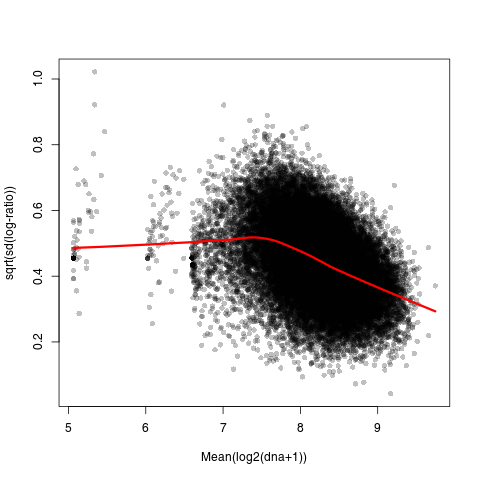

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,"TILE_ID_133-00453|ORF_VIRUS|NC_005336.1|42729,...",-0.979992,-0.508330,-9.403404,0.000003,0.086558,3.942044
1,"TILE_ID_133-00452|ORF_VIRUS|NC_005336.1|42744,...",-0.733187,-0.366757,-7.638827,0.000018,0.218278,2.244528
2,TILE_ID_135-00011|HUMAN_ALPHAHERPESVIRUS_1_(HE...,-0.703696,-0.358169,-7.051001,0.000036,0.218278,1.966192
3,TILE_ID_136-00089|HUMAN_ALPHAHERPESVIRUS_2_(HE...,-0.891714,-0.460479,-6.972075,0.000039,0.218278,1.923465
4,"TILE_ID_133-00323|ORF_VIRUS|NC_005336.1|3517,3...",-0.741799,-0.369609,-6.912835,0.000042,0.218278,1.700453


In [24]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "mean", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEresultmeanWCN = pandas2ri.rpy2py_dataframe(toptab)
DEresultmeanWCN = DEresultmeanWCN.reset_index()
DEresultmeanWCN.head()

[]

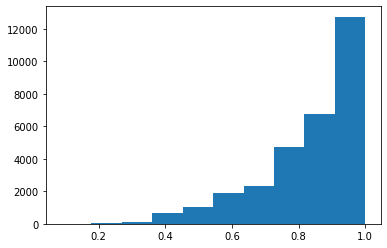

In [40]:
plt.hist(DEresultmeanWCN['adj.P.Val'])
plt.plot()

In [41]:
tmp = DEresultmeanWCN[DEresultmeanWCN['logFC']>0][DEresultmeanWCN['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_listWCN2 = list(tmp['index'])
print(stat_listWCN2)
tmp

(0, 7)
[]


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B


In [42]:
tmp = DEresultmeanWCN[DEresultmeanWCN['logFC']<0][DEresultmeanWCN['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
negstat_listWCN2 = list(tmp['index'])
print(negstat_listWCN2)
tmp

(1, 7)
['TILE_ID_133-00453|ORF_VIRUS|NC_005336.1|42729,42600|PRETILE_ID_133-00125|PREPRETILE_ID_133-00087']


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,"TILE_ID_133-00453|ORF_VIRUS|NC_005336.1|42729,...",-0.979992,-0.50833,-9.403404,0.000003,0.086558,3.942044


# D vs N

In [14]:
countBC_dna = countBC_merge.iloc[:,[0,13,14,15,16]].set_index('alignid')
countBC_dna['ctrl1'] = [50]*len(countBC_dna);countBC_dna['ctrl2'] = [50]*len(countBC_dna);
countBC_dna['ctrl3'] = [50]*len(countBC_dna);countBC_dna['ctrl4'] = [50]*len(countBC_dna)
# countBC_dna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_dna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
countBC_rna = countBC_merge.iloc[:,[0,5,6,7,8]].set_index('alignid')
countBC_rna['ctrl1'] = [50]*len(countBC_rna);countBC_rna['ctrl2'] = [50]*len(countBC_rna);
countBC_rna['ctrl3'] = [50]*len(countBC_rna);countBC_rna['ctrl4'] = [50]*len(countBC_rna);
# countBC_rna.columns = ['rep1','rep2','rep3','c1','c2','c3']
countBC_rna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
species_list = list(countBC_merge.set_index('alignid')['species'])
countBC_dna = countBC_dna +20
countBC_rna = countBC_rna +20
countBC_dna.head()

,rep1,rep2,rep3,rep4,c1,c2,c3,c4
alignid,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ATCGGAA|0",134.0,110.0,115.0,116.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGTACAA|1",132.0,148.0,159.0,167.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|TAAGCGA|2",135.0,189.0,225.0,165.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ACTGGAA|0",90.0,56.0,89.0,29.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGATAGA|2",150.0,195.0,244.0,223.0,70,70,70,70


In [15]:
%Rpush countBC_dna
%Rpush countBC_rna
%Rpush species_list

%R species_list <- unlist(species_list)

array(['TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       ...,
       'TILE_ID_126-00320|HUMAN_CORONAVIRUS_HKU1_(HCOV-HKU1)|NC_006577.2|20814,20943|PRETILE_ID_126-00003|PREPRETILE_ID_126-00001',
       'TILE_ID_141-00231|NY_014_POXVIRUS|NC_035469.1|155593,155722|PRETILE_ID_141-00050|PREPRETILE_ID_141-00050',
       'TILE_ID_142-00108|COWPOX_VIRUS|NC_003663.2|97894,98023|PRETILE_ID_142-00023|PREPRETILE_ID_142-00023'],
      dtype='<U155')

In [16]:
%R mpraset_example <- MPRASet(DNA = countBC_dna, RNA = countBC_rna, eid = species_list, eseq = NULL, barcode = NULL)

R object with classes: ('MPRASet',) mapped to:

  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


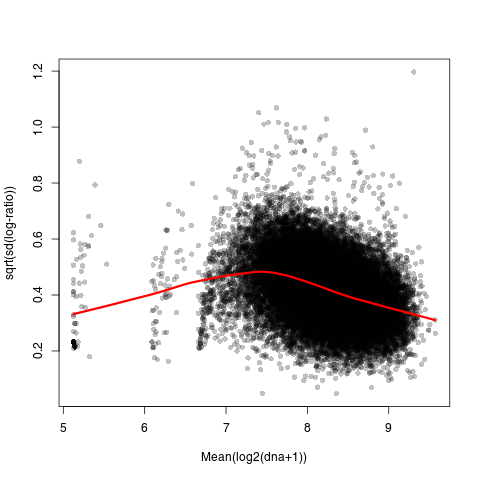

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_032-00024|WOODCHUCK_HEPATITIS_VIRUS|NC...,-2.743252,-1.371931,-47.145567,1.124524e-12,2.799889e-08,18.606720
1,TILE_ID_081-00021|HEPATITIS_GB_VIRUS_B|NC_0016...,-3.137320,-1.566680,-44.750996,1.850004e-12,2.799889e-08,18.160184
2,TILE_ID_138-00224|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.502449,-1.757047,-36.765730,1.206190e-11,1.217006e-07,16.870693
3,TILE_ID_080-00062|GB_VIRUS_C_(GBV-HGV)|NC_0017...,-1.874663,-0.937420,-32.907571,3.466001e-11,2.177644e-07,16.061074
4,TILE_ID_137-00484|HUMAN_BETAHERPESVIRUS_6B_(HH...,-3.652481,-1.821736,-31.639830,5.036013e-11,2.177644e-07,15.670805


In [17]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "mean", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEresultmeanDN = pandas2ri.rpy2py_dataframe(toptab)
DEresultmeanDN = DEresultmeanDN.reset_index()
DEresultmeanDN.head()

[]

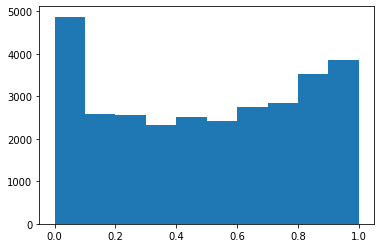

In [18]:
plt.hist(DEresultmeanDN['adj.P.Val'])
plt.plot()

In [19]:
tmp = DEresultmeanDN[DEresultmeanDN['logFC']>0][DEresultmeanDN['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_listDN2 = list(tmp['index'])
# print(stat_listWCN2)
tmp

(1583, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
71,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.882033,0.947648,19.608430,4.635346e-09,0.000002,11.565652
639,TILE_ID_143-00201|HUMAN_BETAHERPESVIRUS_5_(HHV...,1.330443,0.677133,9.240079,4.405563e-06,0.000208,4.523380
421,TILE_ID_075-00103|HUSAVIRUS_SP.|NC_032480.1|66...,1.196020,0.603883,11.147430,8.386633e-07,0.000059,6.393590
99,TILE_ID_133-00301|ORF_VIRUS|NC_005336.1|134347...,1.189958,0.594608,18.197930,9.323023e-09,0.000003,10.883648
516,TILE_ID_076-00050|BORNA_DISEASE_VIRUS_1_(BODV-...,1.152934,0.581240,10.275852,1.732542e-06,0.000101,5.577495
...,...,...,...,...,...,...,...
4175,TILE_ID_143-00135|HUMAN_BETAHERPESVIRUS_5_(HHV...,0.192519,0.096220,3.301800,8.446926e-03,0.065075,-3.551473
5053,"TILE_ID_133-00336|ORF_VIRUS|NC_005336.1|5348,5...",0.192329,0.099101,2.975503,1.453985e-02,0.093441,-4.104192
4642,TILE_ID_135-00242|HUMAN_ALPHAHERPESVIRUS_1_(HE...,0.189421,0.094560,3.119147,1.143690e-02,0.079254,-3.871439
4926,TILE_ID_140-00030|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,0.173052,0.086526,3.028726,1.330045e-02,0.087749,-4.027755


In [20]:
tmp = DEresultmeanDN[DEresultmeanDN['logFC']<0][DEresultmeanDN['adj.P.Val']<0.1].sort_values('logFC',ascending = False)
print(tmp.shape)
negstat_listDN2 = list(tmp['index'])
# print(negstat_listDN2)
tmp

(3294, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
5060,TILE_ID_116-00126|MEASLES_MORBILLIVIRUS|NC_001...,-0.171181,-0.085722,-2.951603,1.513415e-02,9.617798e-02,-4.108827
5261,TILE_ID_138-00143|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-0.177539,-0.088770,-2.918899,1.598770e-02,9.951297e-02,-4.214437
4772,TILE_ID_084-00057|HEPATITIS_C_VIRUS_GENOTYPE_1...,-0.182086,-0.091043,-3.083274,1.214197e-02,8.257140e-02,-3.934976
5215,TILE_ID_143-00519|HUMAN_BETAHERPESVIRUS_5_(HHV...,-0.182348,-0.090511,-2.920528,1.594403e-02,9.939556e-02,-4.193287
4705,TILE_ID_092-00018|YELLOW_FEVER_VIRUS_(YFV)|NC_...,-0.195759,-0.098010,-3.010551,1.371107e-02,8.965661e-02,-3.900743
...,...,...,...,...,...,...,...
104,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,-3.372725,-1.682716,-18.025341,1.019095e-08,2.937809e-06,10.793649
52,TILE_ID_070-00104|AICHI_VIRUS_1|NC_001918.1|66...,-3.406669,-1.703779,-20.824162,2.635127e-09,1.450230e-06,12.137553
2,TILE_ID_138-00224|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.502449,-1.757047,-36.765730,1.206190e-11,1.217006e-07,16.870693
4,TILE_ID_137-00484|HUMAN_BETAHERPESVIRUS_6B_(HH...,-3.652481,-1.821736,-31.639830,5.036013e-11,2.177644e-07,15.670805


# drawing prep

In [41]:
tmp = (count_merge.iloc[:,1:13]/count_merge.iloc[:,1:13].sum())*np.mean(count_merge.iloc[:,1:13].sum())
count_merge = pd.concat([count_merge.iloc[:,0], tmp,count_merge.iloc[:,13:]], axis=1)

tmp = (countBC_merge.iloc[:,1:13]/countBC_merge.iloc[:,1:13].sum())*np.mean(countBC_merge.iloc[:,1:13].sum())
countBC_merge = pd.concat([countBC_merge.iloc[:,0], tmp,countBC_merge.iloc[:,13:]], axis=1)

count_merge.sum()

species      TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...
count_C1                                           2.00936e+07
count_C2                                           2.00936e+07
count_C3                                           2.00936e+07
count_C4                                           2.00936e+07
count_N1                                           2.00936e+07
count_N2                                           2.00936e+07
count_N3                                           2.00936e+07
count_N4                                           2.00936e+07
count_WC1                                          2.00936e+07
count_WC2                                          2.00936e+07
count_WC3                                          2.00936e+07
count_WC4                                          2.00936e+07
virus        ROTAVIRUS_AROTAVIRUS_AROTAVIRUS_AROTAVIRUS_ARO...
site         1,13066,195131,260196,325261,390326,455391,520...
uniqID       TILE_ID_001-00001TILE_ID_001-00002TILE_ID_

In [42]:
psu = 50

for i in range(4):
    count_merge['ratio_N%s'%(i+1)] = (count_merge['count_N%s'%(i+1)]+psu)/(count_merge['count_WC%s'%(i+1)]+psu)
    count_merge['ratio_C%s'%(i+1)] = (count_merge['count_C%s'%(i+1)]+psu)/(count_merge['count_WC%s'%(i+1)]+psu)
    count_merge['ratio_NC%s'%(i+1)] = (count_merge['count_C%s'%(i+1)]+psu)/(count_merge['count_N%s'%(i+1)]+psu)

psu = 20
for i in range(4):
    countBC_merge['ratio_N%s'%(i+1)] = (countBC_merge['count_N%s'%(i+1)]+psu)/(countBC_merge['count_WC%s'%(i+1)]+psu)
    countBC_merge['ratio_C%s'%(i+1)] = (countBC_merge['count_C%s'%(i+1)]+psu)/(countBC_merge['count_WC%s'%(i+1)]+psu)
    countBC_merge['ratio_NC%s'%(i+1)] = (countBC_merge['count_C%s'%(i+1)]+psu)/(countBC_merge['count_N%s'%(i+1)]+psu)

countBC_merge['mean_WC'] = (countBC_merge['count_WC1'] + countBC_merge['count_WC2'] + countBC_merge['count_WC3'] + countBC_merge['count_WC4'])/4
countBC_merge['mean_C'] = (countBC_merge['count_C1'] + countBC_merge['count_C2'] + countBC_merge['count_C3'] + countBC_merge['count_C4'])/4
countBC_merge['mean_N'] = (countBC_merge['count_N1'] + countBC_merge['count_N2'] + countBC_merge['count_N3']  + countBC_merge['count_N4'])/4

count_merge['mean_WC'] = (count_merge['count_WC1'] + count_merge['count_WC2'] + count_merge['count_WC3'] + count_merge['count_WC4'])/4
count_merge['mean_C'] = (count_merge['count_C1'] + count_merge['count_C2'] + count_merge['count_C3'] + count_merge['count_C4'])/4
count_merge['mean_N'] = (count_merge['count_N1'] + count_merge['count_N2'] + count_merge['count_N3']  + count_merge['count_N4'])/4

count_merge.head()

,species,count_C1,count_C2,count_C3,count_C4,count_N1,count_N2,count_N3,count_N4,count_WC1,...,ratio_NC2,ratio_N3,ratio_C3,ratio_NC3,ratio_N4,ratio_C4,ratio_NC4,mean_WC,mean_C,mean_N
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",328.868210,442.093421,251.363504,352.987858,361.386953,323.115217,405.008535,448.718110,371.222763,...,1.318878,1.053235,0.697584,0.662325,1.598311,1.291511,0.808047,356.548669,343.828248,384.557203
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",337.940436,247.180312,186.701154,306.053184,357.160205,317.852754,248.656403,310.505359,310.519670,...,0.807878,0.757236,0.600150,0.792553,0.920994,0.909620,0.987650,290.116063,269.468771,308.543680
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",388.971710,500.894024,416.206962,444.901594,443.808538,385.212278,479.417079,413.691590,565.005715,...,1.265805,1.394825,1.228289,0.880604,1.196745,1.277295,1.067308,410.739450,437.743572,430.532372
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",567.014154,970.209947,824.217288,617.973203,872.823459,811.471766,728.073482,784.783360,838.947880,...,1.184264,0.806754,0.906442,1.123566,0.914821,0.732018,0.800176,838.765486,744.853648,799.288017
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",362.889059,431.204421,341.526500,245.429231,252.548192,355.742486,359.798280,464.811375,379.005211,...,1.185985,1.167989,1.115912,0.955413,1.599024,0.917614,0.573859,294.080038,345.262303,358.225083


# positive controls

In [46]:
SL27_pos_sp = count_merge[count_merge['species'].str.contains('SL27')][
    count_merge['species'].str.contains('POSITIVE')][
    count_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=11)][count_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=8)] #3~12
# SL27_neg = count_merge[count_merge['species'].str.contains('SL27')][count_merge['species'].str.contains('POSITIVE|NEGATIVE')]
SL27_neg_sp = count_merge[count_merge['species'].str.contains('SL27')][
    count_merge['species'].str.contains('NEGATIVE')][
    count_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=11)][count_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=8)] #3~12

PRE_sp = count_merge[count_merge['species'].apply(lambda x: 'PRE' in x.split('|')[1])]
# PRE

SL27_pos_sp

,species,count_C1,count_C2,count_C3,count_C4,count_N1,count_N2,count_N3,count_N4,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,virus,site,uniqID
30214,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,2064.0,2044.0,2434.0,2551.0,2032.0,2178.0,2903.0,2596.0,3096.0,1716.0,2187.0,2165.0,1423.0,1548.0,1890.0,1623.0,POSITIVE_CONTROL(SL27),"70,200",TILE_ID_144-00008
30215,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,2233.0,1676.0,2165.0,2305.0,2110.0,1840.0,2490.0,2281.0,2658.0,1776.0,1841.0,1975.0,1265.0,1251.0,1269.0,1251.0,POSITIVE_CONTROL(SL27),"80,210",TILE_ID_144-00009
30216,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,1804.0,1763.0,1923.0,2251.0,2078.0,1741.0,2142.0,2281.0,2807.0,1756.0,1792.0,2126.0,1170.0,1198.0,1341.0,1208.0,POSITIVE_CONTROL(SL27),"90,220",TILE_ID_144-00010
30217,TILE_ID_144-00011|POSITIVE_CONTROL(SL27)|GU937...,1290.0,1465.0,1715.0,1722.0,1635.0,1598.0,1717.0,1685.0,2880.0,1624.0,1548.0,1762.0,976.0,1101.0,1060.0,1153.0,POSITIVE_CONTROL(SL27),"100,230",TILE_ID_144-00011


In [47]:
SL27_pos = countBC_merge[countBC_merge['species'].str.contains('SL27')][
    countBC_merge['species'].str.contains('POSITIVE')][
    countBC_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=11)][countBC_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=8)] #3~12
# SL27_neg = countBC_merge[countBC_merge['species'].str.contains('SL27')][countBC_merge['species'].str.contains('POSITIVE|NEGATIVE')]
SL27_neg = countBC_merge[countBC_merge['species'].str.contains('SL27')][
    countBC_merge['species'].str.contains('NEGATIVE')][
    countBC_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=11)][countBC_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=8)] #3~12

PRE = countBC_merge[countBC_merge['species'].apply(lambda x: 'PRE' in x.split('|')[1])][
    countBC_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])<=13)][countBC_merge['species'].apply(
        lambda x : int(x.split('|')[0].split('-')[-1])>=6)] #3~12
# PRE

SL27_pos

,alignid,count_C1,count_C2,count_C3,count_C4,count_N1,count_N2,count_N3,count_N4,count_WC1,...,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,species,virus,site,uniqID
89134,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,481.0,563.0,528.0,716.0,426.0,589.0,555.0,679.0,641.0,...,500.0,510.0,382.0,395.0,445.0,336.0,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"70,200",TILE_ID_144-00008
89135,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,647.0,856.0,1070.0,839.0,728.0,921.0,1356.0,851.0,1250.0,...,929.0,770.0,546.0,577.0,667.0,530.0,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"70,200",TILE_ID_144-00008
89136,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,936.0,625.0,836.0,996.0,878.0,668.0,992.0,1066.0,1205.0,...,758.0,885.0,495.0,576.0,778.0,757.0,TILE_ID_144-00008|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"70,200",TILE_ID_144-00008
89137,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,496.0,496.0,491.0,650.0,358.0,329.0,595.0,502.0,825.0,...,412.0,665.0,266.0,271.0,314.0,311.0,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"80,210",TILE_ID_144-00009
89138,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,898.0,401.0,669.0,603.0,717.0,681.0,792.0,701.0,917.0,...,545.0,534.0,421.0,402.0,394.0,406.0,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"80,210",TILE_ID_144-00009
89139,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,839.0,779.0,1005.0,1052.0,1035.0,830.0,1103.0,1078.0,916.0,...,884.0,776.0,578.0,578.0,561.0,534.0,TILE_ID_144-00009|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"80,210",TILE_ID_144-00009
89140,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,440.0,356.0,529.0,643.0,516.0,380.0,438.0,551.0,821.0,...,389.0,581.0,318.0,278.0,282.0,304.0,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"90,220",TILE_ID_144-00010
89141,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,810.0,726.0,947.0,761.0,857.0,749.0,1070.0,1014.0,936.0,...,901.0,866.0,452.0,531.0,549.0,495.0,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"90,220",TILE_ID_144-00010
89142,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,554.0,681.0,447.0,847.0,705.0,612.0,634.0,716.0,1050.0,...,502.0,679.0,400.0,389.0,510.0,409.0,TILE_ID_144-00010|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"90,220",TILE_ID_144-00010
89143,TILE_ID_144-00011|POSITIVE_CONTROL(SL27)|GU937...,476.0,518.0,531.0,538.0,536.0,520.0,559.0,522.0,892.0,...,635.0,523.0,323.0,366.0,347.0,299.0,TILE_ID_144-00011|POSITIVE_CONTROL(SL27)|GU937...,POSITIVE_CONTROL(SL27),"100,230",TILE_ID_144-00011


## drawing

In [46]:
def log_tf(x):
    return np.log2(x+1)

In [43]:
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

savedir = '/casa/jenny/notebooks/pan-viral_MPRA/paper_figures/'

In [72]:
with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/df_vst(polysome).pickle', 'rb') as f:
    df_vst = pickle.load(f)
names = ['index']+list(df_vst.columns[2:])

df_vst = df_vst.iloc[:,1:]
df_vst.columns = names
df_vst['HP/Free'] = df_vst['count_HP']-  df_vst['count_Free']
df_vst.head()

,index,count_Free_rep1,count_Mono_rep1,count_LP_rep1,count_MP_rep1,count_HP_rep1,count_Free_rep2,count_Mono_rep2,count_LP_rep2,count_MP_rep2,...,count_Free,count_Mono,count_LP,count_MP,count_HP,count_mean,count_mean_rep1,count_mean_rep2,count_mean_rep3,HP/Free
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",-0.033954,-0.180318,-0.043099,0.091188,0.166183,0.013546,-0.098501,0.028203,0.008387,...,-0.016154,-0.081206,0.004113,-0.041997,0.135245,8.640875,8.673256,8.604103,8.645265,0.151398
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",-0.038675,-0.055031,-0.007136,-0.164136,0.264978,-0.021066,0.028705,0.030687,0.013068,...,-0.072254,0.063563,0.009742,-0.026464,0.025413,8.212752,8.187729,8.259393,8.191135,0.097667
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",0.097699,-0.232190,0.057418,-0.080691,0.157764,-0.013426,-0.035434,0.081903,0.003163,...,0.081682,-0.104132,-0.001355,-0.019415,0.043220,8.646349,8.668721,8.687085,8.583240,-0.038463
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",-0.100119,0.060953,0.047743,-0.039092,0.030515,-0.084931,0.053629,-0.024347,-0.011425,...,-0.049163,0.005683,-0.030662,0.008686,0.065457,9.821536,9.800433,9.848725,9.815451,0.114620
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",0.126180,-0.122387,-0.160202,0.040849,0.115560,-0.037348,0.089589,0.004423,0.029995,...,0.107286,-0.060475,-0.057522,0.033995,-0.023284,8.285539,8.253359,8.259673,8.343585,-0.130571


In [44]:

C1_sp = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001'
K5_sp = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001'
K4_sp = 'TILE_ID_069-00123|SAFFOLD_VIRUS|NC_009448.2|7931,8060|PRETILE_ID_069-00001|PREPRETILE_ID_069-00001'

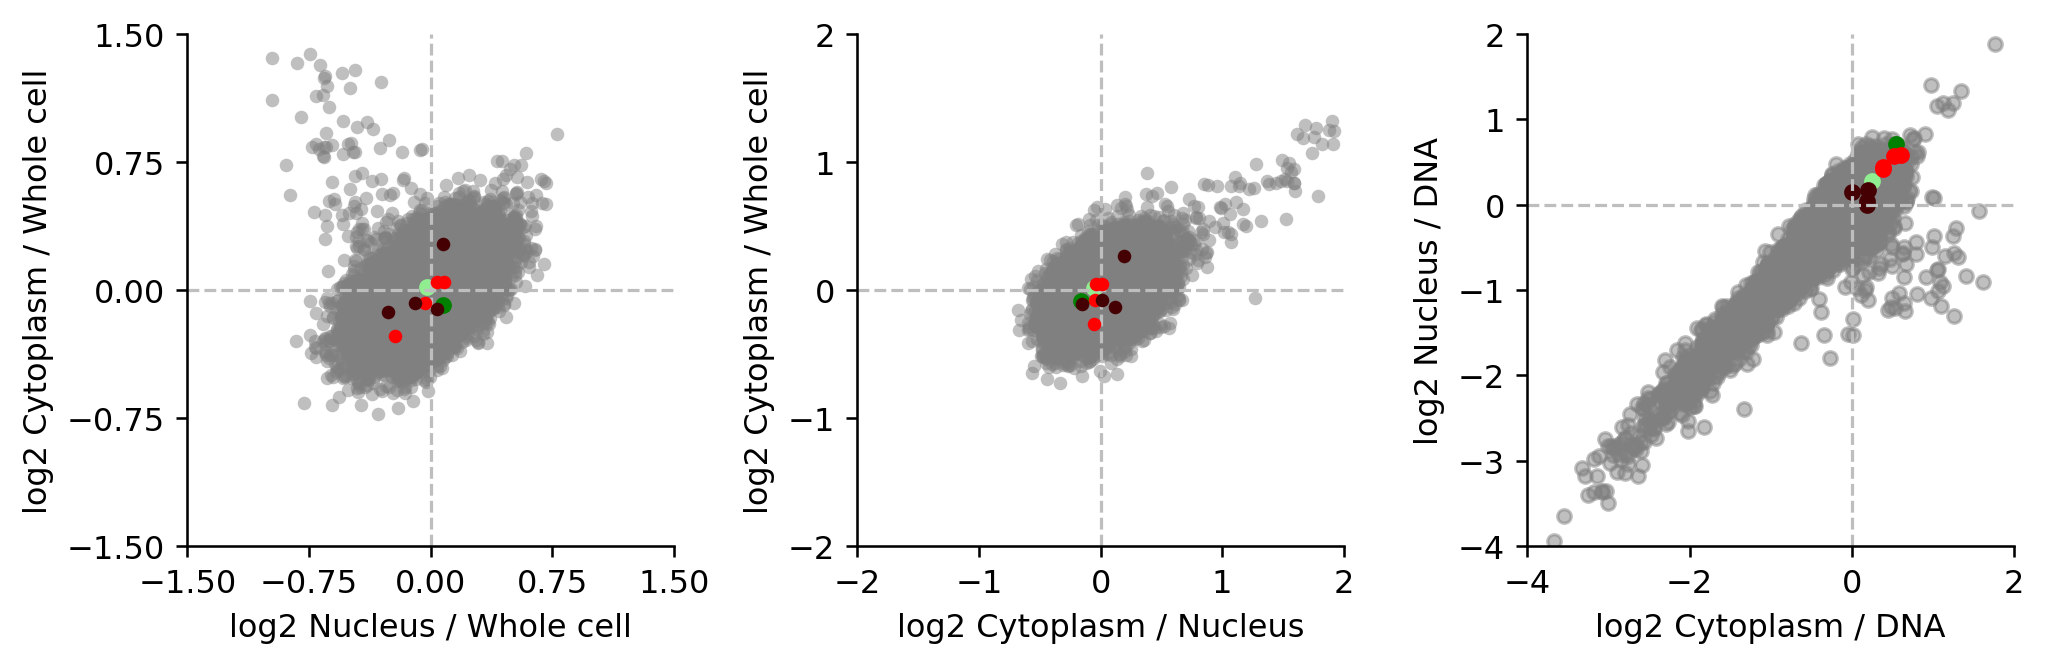

In [51]:
fig, ax = plt.subplots(1,3,figsize=(9,3),dpi = 230)
size = 18;alpha = 0.5


###########################################
tmp_df = pd.merge(DEresultmeanWCN,DEresultmeanWCC,on='index',suffixes=('_N','_C'))
ax[0].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)

tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size,zorder =2,linewidth=0)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size,zorder =2,linewidth=0)
ax[0].set_xlabel('log2 Nucleus / Whole cell')
ax[0].set_ylabel('log2 Cytoplasm / Whole cell')
ax[0].set_xlim(-1.5,1.5)
ax[0].set_ylim(-1.5,1.5)
ax[0].set_yticks([-1.5, -0.75, 0,0.75,1.5])
ax[0].set_xticks([-1.5, -0.75, 0,0.75,1.5])
# ax[0].set_xticklabels([-1.5, -0.75, 0,0.75,1.5], rotation=90)
# ax[0].set_title('RNA vs Translation%s'%str(a))

#############################################
tmp_df = pd.merge(DEresultmeanNC,DEresultmeanWCC,on='index',suffixes=('_N','_C'))
ax[1].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)

tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size,zorder =2,linewidth=0)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size,zorder =2,linewidth=0)

ax[1].set_xlabel('C/N')
ax[1].set_ylabel('C/WC')

ax[1].set_xlabel('log2 Cytoplasm / Nucleus')
ax[1].set_ylabel('log2 Cytoplasm / Whole cell')
ax[1].set_yticks([-2, -1, 0,1,2])
ax[1].set_xticks([-2, -1, 0,1,2])
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2)
# ax[1].set_title('RNA vs Translation%s'%str(a))


##########################################
tmp_df = pd.merge(DEresultmeanDC,DEresultmeanDN,on='index',suffixes=('_N','_C'))
ax[2].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)

tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size)

ax[2].set_xlabel('log2 Cytoplasm / DNA')
ax[2].set_ylabel('log2 Nucleus / DNA')
ax[2].set_xlim(-4,2)
ax[2].set_ylim(-4,2)

for i in range(3):
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)


ax[0].plot((-1.5,1.5),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)
ax[1].plot((-2,2),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)
ax[2].plot((-4,2),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)

ax[0].plot((0,0),(-1.5,1.5), '--',color =  '#BEBEBE',zorder=1, lw=1)
ax[1].plot((0,0),(-2,2), '--',color =  '#BEBEBE',zorder=1, lw=1)
ax[2].plot((0,0),(-4,2), '--',color =  '#BEBEBE',zorder=1, lw=1)

plt.tight_layout()

fig.savefig(savedir + 'Figure_NC-fraction.pdf', format='pdf', transparent=True, bbox_inches='tight')

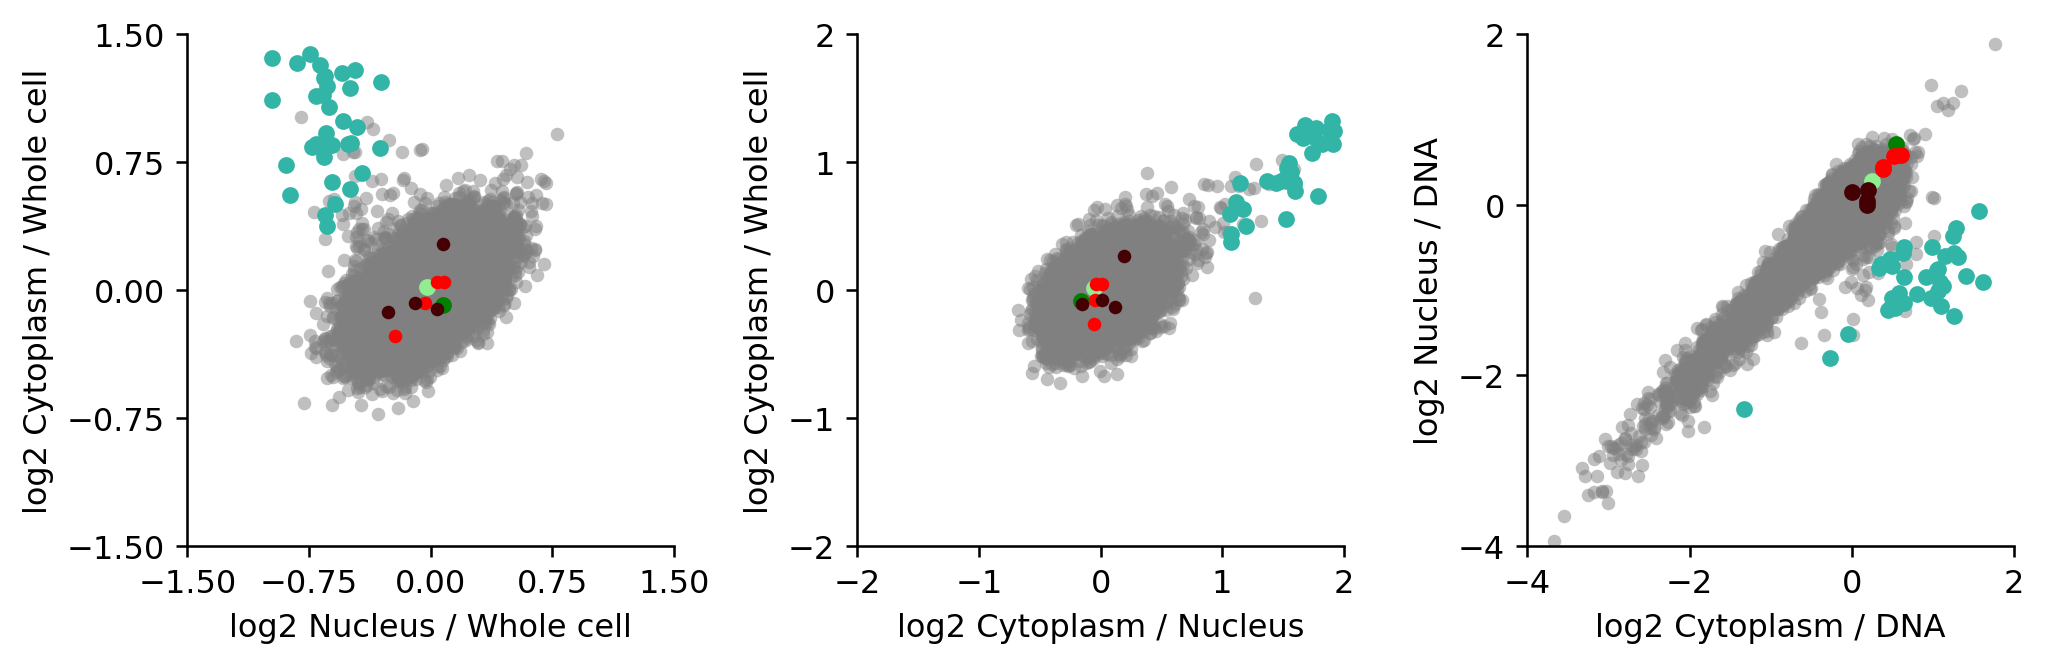

In [89]:
fig, ax = plt.subplots(1,3,figsize=(9,3),dpi = 230)
size = 18;alpha = 0.5


###########################################
tmp_df = pd.merge(DEresultmeanWCN,DEresultmeanWCC,on='index',suffixes=('_N','_C'))
ax[0].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)

#************iltering**************#
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>1][DEresultmeanNC['adj.P.Val']<0.05]

tmp = tmp_df[tmp_df['index'].isin(tmp['index'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#32b4a7',s=size)
#************iltering**************#

tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size,zorder =2,linewidth=0)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size,zorder =2,linewidth=0)
ax[0].set_xlabel('log2 Nucleus / Whole cell')
ax[0].set_ylabel('log2 Cytoplasm / Whole cell')
ax[0].set_xlim(-1.5,1.5)
ax[0].set_ylim(-1.5,1.5)
ax[0].set_yticks([-1.5, -0.75, 0,0.75,1.5])
ax[0].set_xticks([-1.5, -0.75, 0,0.75,1.5])
# ax[0].set_xticklabels([-1.5, -0.75, 0,0.75,1.5], rotation=90)
# ax[0].set_title('RNA vs Translation%s'%str(a))

#############################################
tmp_df = pd.merge(DEresultmeanNC,DEresultmeanWCC,on='index',suffixes=('_N','_C'))
ax[1].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)
#************iltering**************#
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>1][DEresultmeanNC['adj.P.Val']<0.05]

tmp = tmp_df[tmp_df['index'].isin(tmp['index'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#32b4a7',s=size)
#************iltering**************#
tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size,zorder =2,linewidth=0)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size,zorder =2,linewidth=0)

ax[1].set_xlabel('C/N')
ax[1].set_ylabel('C/WC')

ax[1].set_xlabel('log2 Cytoplasm / Nucleus')
ax[1].set_ylabel('log2 Cytoplasm / Whole cell')
ax[1].set_yticks([-2, -1, 0,1,2])
ax[1].set_xticks([-2, -1, 0,1,2])
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2)
# ax[1].set_title('RNA vs Translation%s'%str(a))


##########################################
tmp_df = pd.merge(DEresultmeanDC,DEresultmeanDN,on='index',suffixes=('_N','_C'))
ax[2].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized =True, linewidth=0)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)
#************iltering**************#
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>1][DEresultmeanNC['adj.P.Val']<0.05]

tmp = tmp_df[tmp_df['index'].isin(tmp['index'])]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#32b4a7',s=size)
#************iltering**************#
tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[2].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size)

ax[2].set_xlabel('log2 Cytoplasm / DNA')
ax[2].set_ylabel('log2 Nucleus / DNA')
ax[2].set_xlim(-4,2)
ax[2].set_ylim(-4,2)
ax[2].set_yticks([-4,-2,0,2])

for i in range(3):
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)


# ax[0].plot((-1.5,1.5),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)
# ax[1].plot((-2,2),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)
# ax[2].plot((-4,2),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)

# ax[0].plot((0,0),(-1.5,1.5), '--',color =  '#BEBEBE',zorder=1, lw=1)
# ax[1].plot((0,0),(-2,2), '--',color =  '#BEBEBE',zorder=1, lw=1)
# ax[2].plot((0,0),(-4,2), '--',color =  '#BEBEBE',zorder=1, lw=1)

plt.tight_layout()

fig.savefig(savedir + 'Figure_NC-fraction.pdf', format='pdf', transparent=True, bbox_inches='tight')

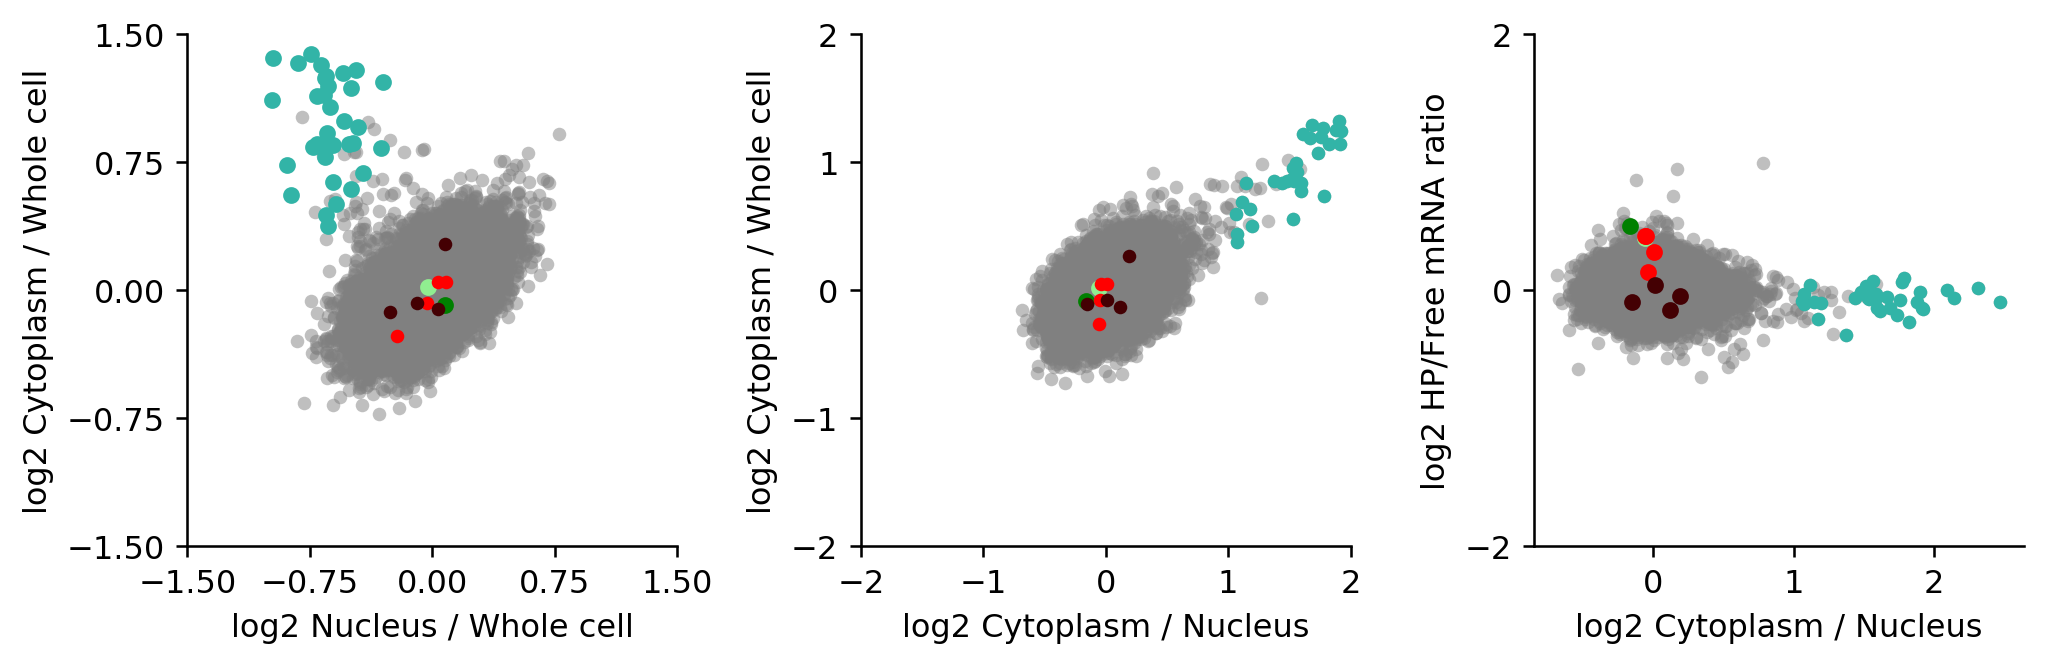

In [88]:
fig, ax = plt.subplots(1,3,figsize=(9,3),dpi = 230)
size = 18;alpha = 0.5

tmp_df = pd.merge(DEresultmeanWCN,DEresultmeanWCC,on='index',suffixes=('_N','_C'))
ax[0].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)


tmp = tmp_df[tmp_df['index']==C1_sp]



tmp = tmp_df[tmp_df['index']==K5_sp]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)
#************iltering**************#
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>1][DEresultmeanNC['adj.P.Val']<0.05]

tmp = tmp_df[tmp_df['index'].isin(tmp['index'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#32b4a7',s=size)
#************iltering**************#
tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size,zorder =2,linewidth=0)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[0].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size,zorder =2,linewidth=0)
ax[0].set_xlabel('log2 Nucleus / Whole cell')
ax[0].set_ylabel('log2 Cytoplasm / Whole cell')
ax[0].set_xlim(-1.5,1.5)
ax[0].set_ylim(-1.5,1.5)
ax[0].set_yticks([-1.5, -0.75, 0,0.75,1.5])
ax[0].set_xticks([-1.5, -0.75, 0,0.75,1.5])
# ax[0].set_xticklabels([-1.5, -0.75, 0,0.75,1.5], rotation=90)
# ax[0].set_title('RNA vs Translation%s'%str(a))


tmp_df = pd.merge(DEresultmeanNC,DEresultmeanWCC,on='index',suffixes=('_N','_C'))
ax[1].scatter(tmp_df['logFC_N'],tmp_df['logFC_C'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)

tmp = tmp_df[tmp_df['index']==K5_sp]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='lightgreen',s=size)
#************iltering**************#
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>1][DEresultmeanNC['adj.P.Val']<0.05]

tmp = tmp_df[tmp_df['index'].isin(tmp['index'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#32b4a7',s=size,zorder =2,linewidth=0)
#************iltering**************#
tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='red',s=size,zorder =2,linewidth=0)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[1].scatter(tmp['logFC_N'],tmp['logFC_C'],color='#440003',s=size,zorder =2,linewidth=0)

ax[1].set_xlabel('C/N')
ax[1].set_ylabel('C/WC')

ax[1].set_xlabel('log2 Cytoplasm / Nucleus')
ax[1].set_ylabel('log2 Cytoplasm / Whole cell')
ax[1].set_yticks([-2, -1, 0,1,2])
ax[1].set_xticks([-2, -1, 0,1,2])
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2)
# ax[1].set_title('RNA vs Translation%s'%str(a))


tmp_df = pd.merge(DEresultmeanNC,df_vst,on='index',suffixes=('_N','_C'))
ax[2].scatter(tmp_df['logFC'],tmp_df['HP/Free'],color='grey',s=size, alpha = alpha,rasterized = True,linewidth=0)


tmp = tmp_df[tmp_df['index']==K5_sp]
ax[2].scatter(tmp['logFC'],tmp['HP/Free'],color='green',s=size)
tmp = tmp_df[tmp_df['index']==K4_sp]
ax[2].scatter(tmp['logFC'],tmp['HP/Free'],color='lightgreen',s=size)
#************iltering**************#
tmp = DEresultmeanNC[DEresultmeanNC['logFC']>1][DEresultmeanNC['adj.P.Val']<0.05]

tmp = tmp_df[tmp_df['index'].isin(tmp['index'])]
ax[2].scatter(tmp['logFC'],tmp['HP/Free'],color='#32b4a7',s=size,zorder =2,linewidth=0)
#************iltering**************#
tmp = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
ax[2].scatter(tmp['logFC'],tmp['HP/Free'],color='red',s=size)
tmp = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]
ax[2].scatter(tmp['logFC'],tmp['HP/Free'],color='#440003',s=size)

ax[2].set_xlabel('log2 Cytoplasm / Nucleus')
ax[2].set_ylabel('log2 HP/Free mRNA ratio')

ax[2].set_ylim((-2,2))

ax[2].set_yticks([-2,0,2])


# ax[2].set_title('RNA vs Translation%s'%str(a))
for i in range(3):
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)


# ax[0].plot((-1.5,1.5),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)
# ax[1].plot((-2,2),(0,0), '--',color =  '#BEBEBE',zorder=1, lw=1)

# ax[0].plot((0,0),(-1.5,1.5), '--',color =  '#BEBEBE',zorder=1, lw=1)
# ax[1].plot((0,0),(-2,2), '--',color =  '#BEBEBE',zorder=1, lw=1)

plt.tight_layout()
fig.savefig(savedir + 'Figure_NC-fraction2.pdf', format='pdf', transparent=True, bbox_inches='tight')

In [79]:
tmp_df = DEresultmeanNC.sort_values('logFC',ascending=False).head(n=25).reset_index()

[print('%s.'%(i+1),'\t'.join(x.split('|')[1:4]+[str('%.4f'%tmp_df.loc[i,'logFC'])])) for i,x in enumerate(tmp_df.head(n=25)['index'])]


1. RUBELLA_VIRUS	NC_001545.2	2716,2845	2.4543
2. ORF_VIRUS	NC_005336.1	134240,134369	2.2846
3. ORF_VIRUS	NC_005336.1	42729,42600	2.1357
4. ORF_VIRUS	NC_005336.1	3517,3388	2.1007
5. ORF_VIRUS	NC_005336.1	77525,77396	1.9176
6. HUMAN_ALPHAHERPESVIRUS_1_(HERPES_SIMPLEX_VIRUS_1)	NC_001806.2	122227,122356	1.9166
7. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	52102,52231	1.9033
8. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	139335,139464	1.8811
9. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	126126,126255	1.8217
10. ORF_VIRUS	NC_005336.1	67667,67796	1.7794
11. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	32924,33053	1.7722
12. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	123458,123587	1.7712
13. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	127231,127360	1.7334
14. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2)	NC_001798.2	32604,32733	1.6981
15. ORF_VIRUS	NC_005336.1	126797,126926	1.6719


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]